In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
plt.rcParams['font.family'] = 'Noto Sans CJK JP'

from IPython.display import Audio

from module import config_lib, utils_lib

In [103]:
class DatasetConfig:
    def __init__(self, kaggle_notebook=False, debug=False):
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'
            
            self.spectrogram_npy = '../data/processed/baseline/birdclef2025_melspec_5sec_256_256.npy'
            self.pseudo_label_csv = "../data/processed/pseudo_labels/ensemble_7sec_pseudoth0.5/pseudo_label.csv"
            self.pseudo_melspec_npy = "../data/processed/train_soundscapes_0407/train_soundscapes_melspecs.npy"


        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 5 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 512
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        self.N_MAX = 50 if self.debug else None        
        self.N_JOBS = 16  # 並列処理のスレッド数 16くらいでいい
        self.LOAD_ENGINE = 'torchaudio'  # librosa or torchaudio
        self.SKIP_RESIZE = False  # resizeしないならTrue
        self.seed = 42
            

In [104]:
cfg = DatasetConfig()
utils_lib.set_seed(cfg.seed)

In [7]:
train_label = pd.read_csv(cfg.train_csv)
submission = pd.read_csv(cfg.submission_csv)
taxonomy = pd.read_csv(cfg.taxonomy_csv)

In [8]:
train_label.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [9]:
taxonomy.head()

,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta


In [10]:
df = pd.merge(train_label, taxonomy[["primary_label", "inat_taxon_id","class_name"]], on='primary_label', how='left')
df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,inat_taxon_id,class_name
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta


In [11]:
print("\n欠損値:\n", df.isnull().sum())
print("\nデータ型:\n", df.dtypes)



欠損値:
 primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
inat_taxon_id         0
class_name            0
dtype: int64

データ型:
 primary_label        object
secondary_labels     object
type                 object
filename             object
collection           object
rating              float64
url                  object
latitude            float64
longitude           float64
scientific_name      object
common_name          object
author               object
license              object
inat_taxon_id         int64
class_name           object
dtype: object


In [12]:

# --- primary_label の分布 ---
print("\nprimary_label のユニーク数:", df['primary_label'].nunique())
print("\nprimary_label 上位10件:\n", df['primary_label'].value_counts().head(10))




primary_label のユニーク数: 206

primary_label 上位10件:
 primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
whtdov     572
socfly1    543
yeofly1    525
bobfly1    514
wbwwre1    499
Name: count, dtype: int64


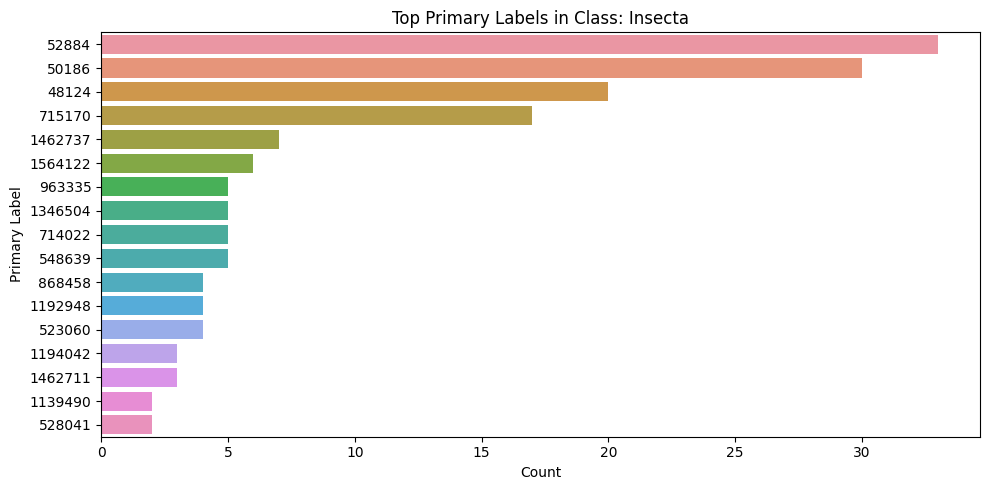

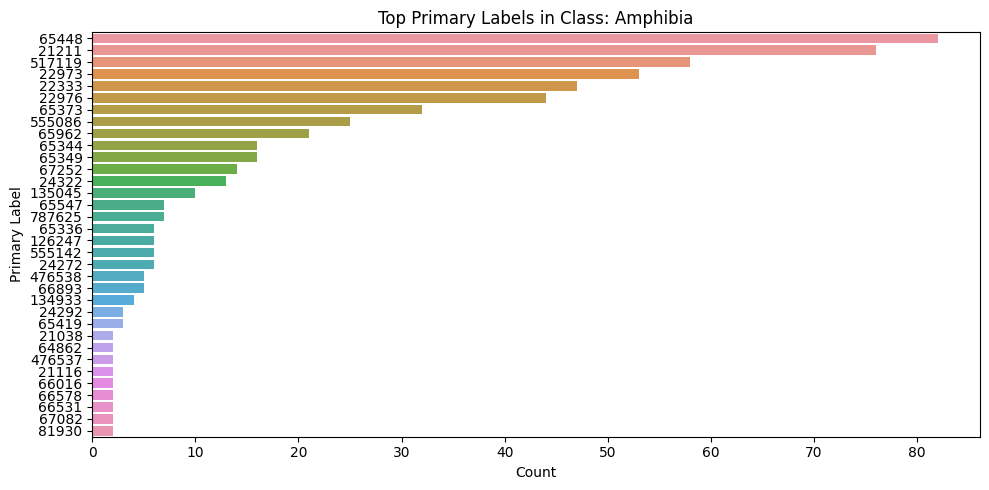

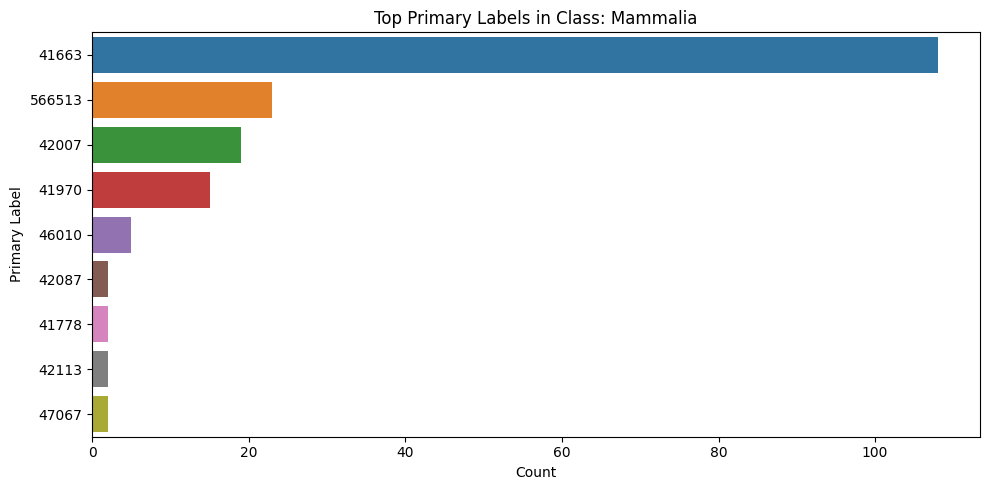

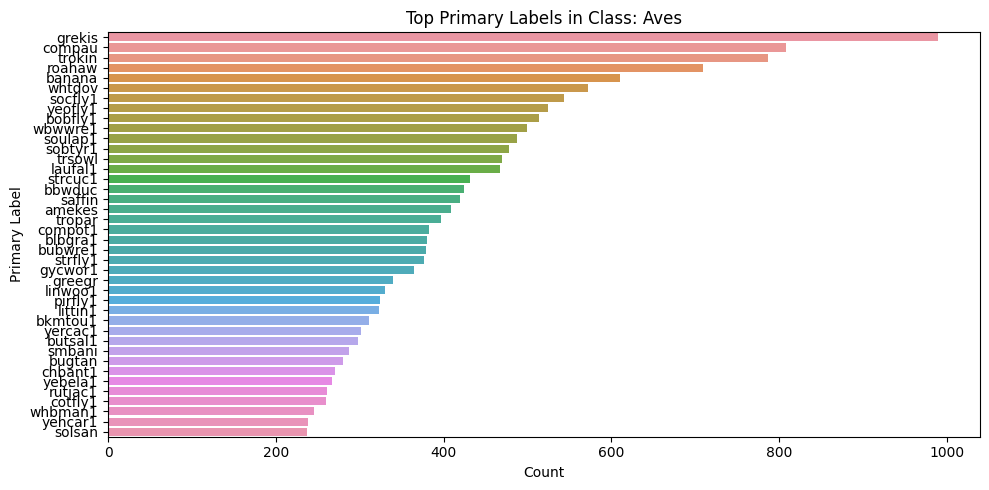

In [13]:
df[df["class_name"] == "Aves"].value_counts("primary_label").head(10)

# class_name ごとに primary_label の出現数トップ10を抽出
top_labels_per_class = {}
for class_name in df['class_name'].unique():
    top_labels = df[df["class_name"] == class_name].value_counts("primary_label").head(40)
    top_labels_per_class[class_name] = top_labels

# 棒グラフで可視化（クラスごとに別のグラフ）
for class_name, label_counts in top_labels_per_class.items():
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.values, y=label_counts.index)
    plt.title(f'Top Primary Labels in Class: {class_name}')
    plt.xlabel('Count')
    plt.ylabel('Primary Label')
    plt.tight_layout()
    plt.show()

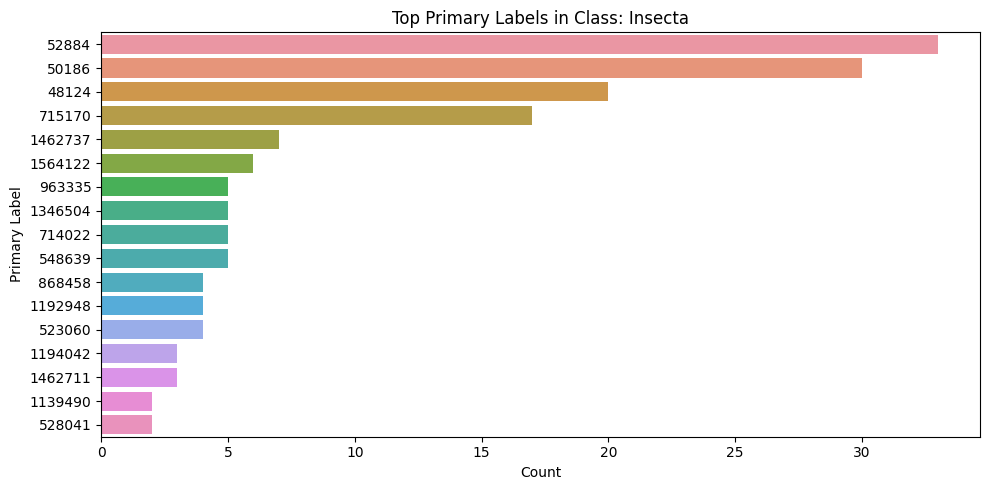

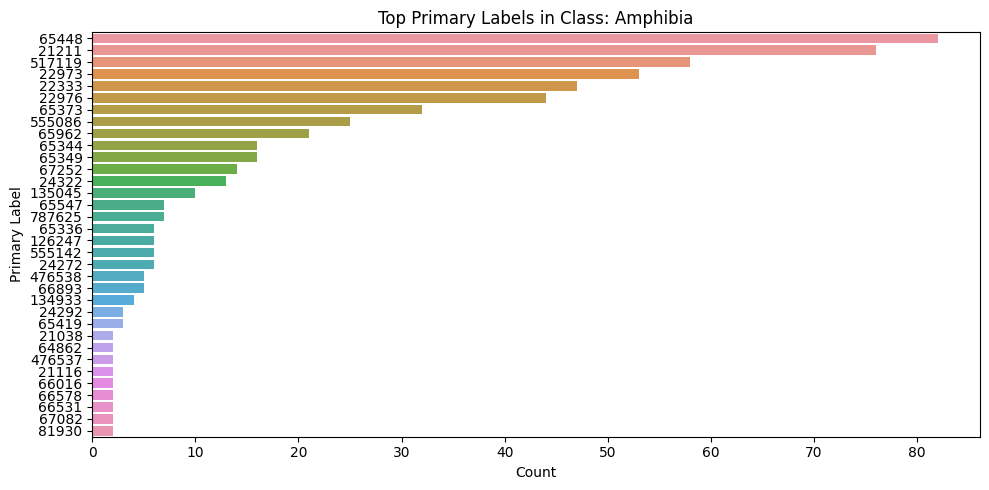

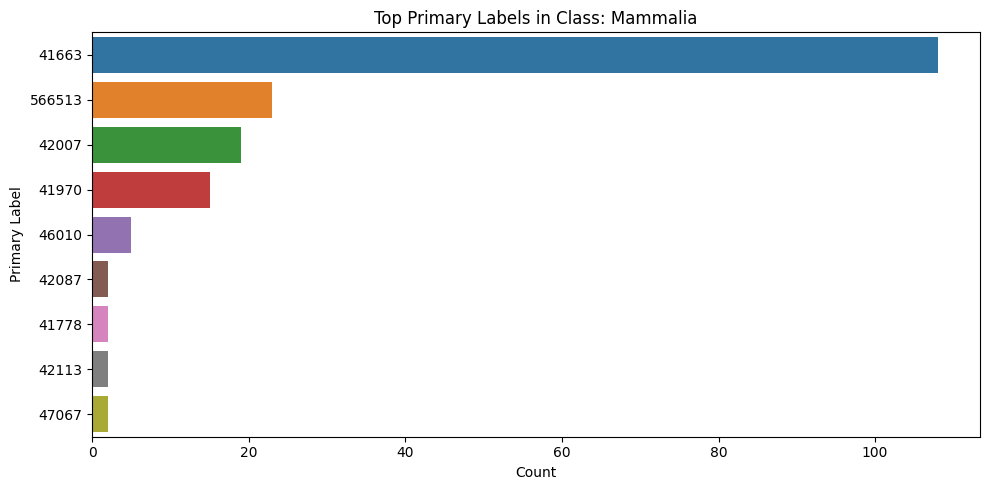

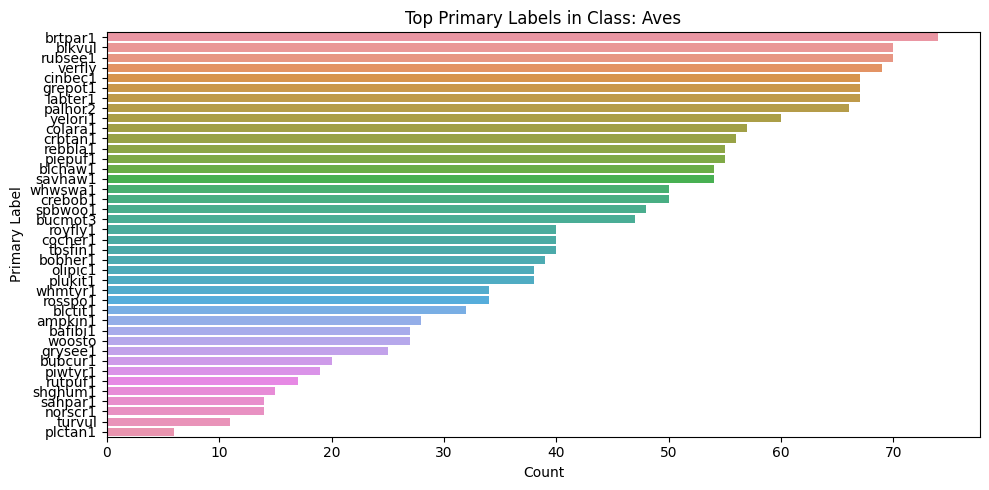

In [14]:

# 出現数ボトム40
top_labels_per_class = {}
for class_name in df['class_name'].unique():
    top_labels = df[df["class_name"] == class_name].value_counts("primary_label").tail(40)
    top_labels_per_class[class_name] = top_labels

# 棒グラフで可視化（クラスごとに別のグラフ）
for class_name, label_counts in top_labels_per_class.items():
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.values, y=label_counts.index)
    plt.title(f'Top Primary Labels in Class: {class_name}')
    plt.xlabel('Count')
    plt.ylabel('Primary Label')
    plt.tight_layout()
    plt.show()


class_name ごとの primary_label のユニーク数:
   class_name  primary_label
1       Aves            146
0   Amphibia             34
2    Insecta             17
3   Mammalia              9


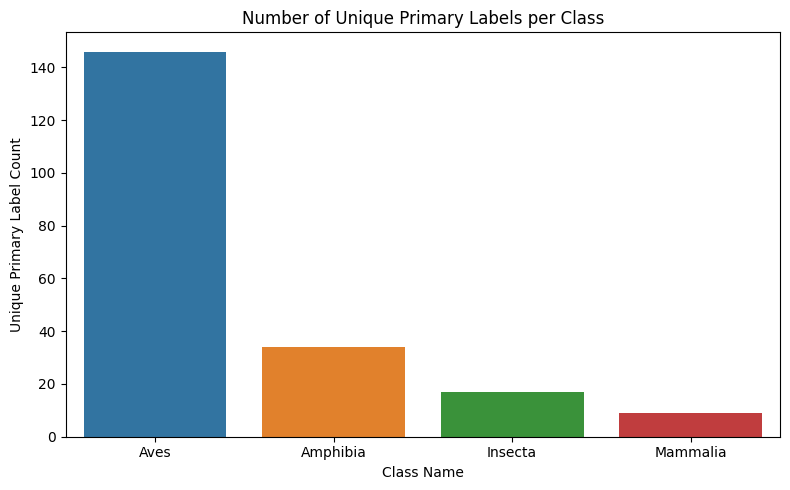

In [15]:
# 生物種ごとのラベル数
# class_name ごとの primary_label のユニーク数をカウント
label_counts = df.groupby('class_name')['primary_label'].nunique().reset_index()
label_counts = label_counts.sort_values('primary_label', ascending=False)

print("\nclass_name ごとの primary_label のユニーク数:\n", label_counts)

plt.figure(figsize=(8, 5))
sns.barplot(data=label_counts, x='class_name', y='primary_label')
plt.title('Number of Unique Primary Labels per Class')
plt.xlabel('Class Name')
plt.ylabel('Unique Primary Label Count')
plt.tight_layout()
plt.show()


class_name の分布:
 class_name
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


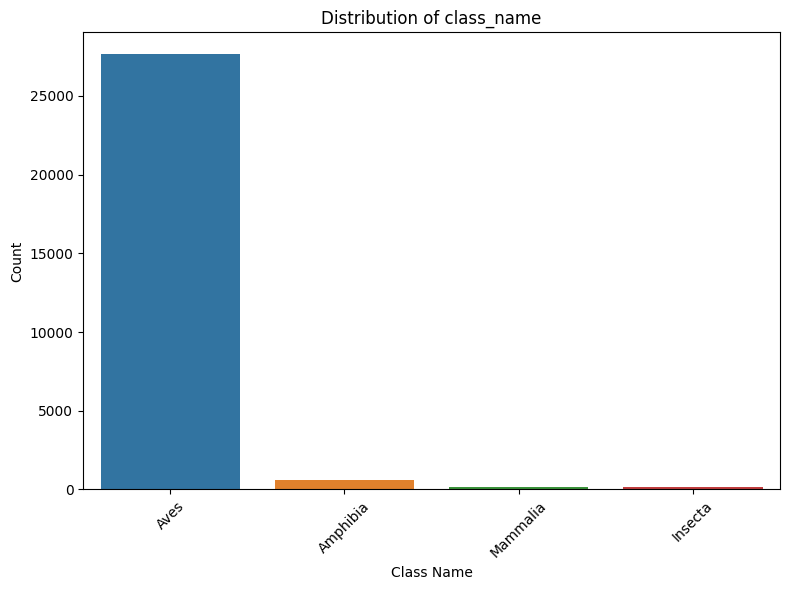

In [16]:
# --- class_name の分布 ---
print("\nclass_name の分布:\n", df['class_name'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='class_name', order=df['class_name'].value_counts().index)
plt.title('Distribution of class_name')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


rating の分布:
 rating
0.0    7948
0.5      26
1.0     228
1.5      70
2.0     752
2.5     360
3.0    2886
3.5     895
4.0    7582
4.5    1261
5.0    6556
Name: count, dtype: int64


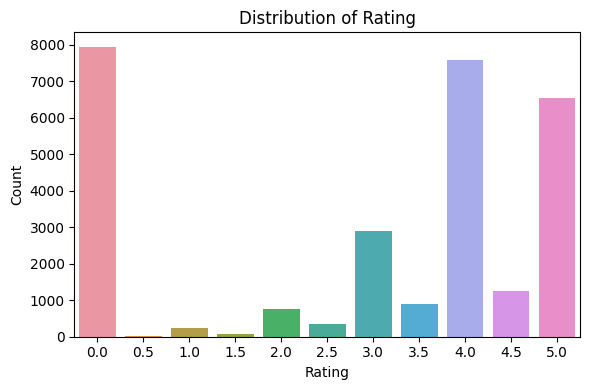

In [17]:

# --- rating の分布 ---
print("\nrating の分布:\n", df['rating'].value_counts().sort_index())


plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='rating', order=sorted(df['rating'].unique()))
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

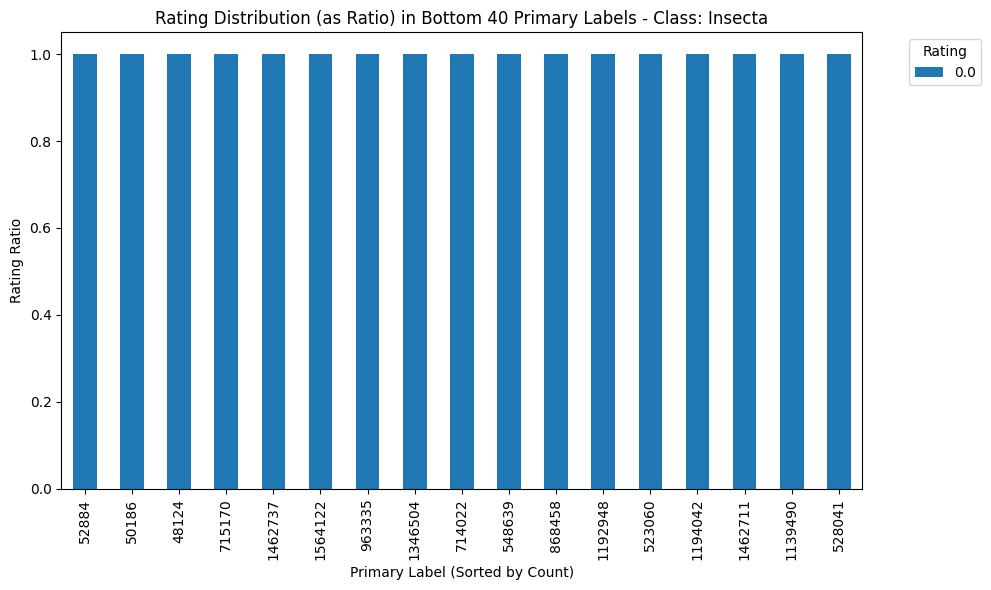

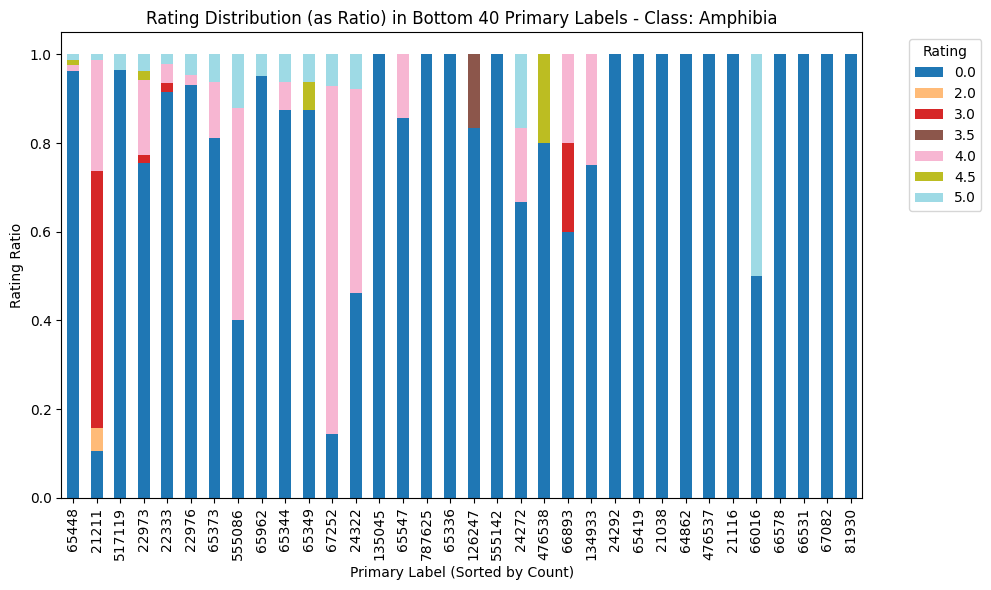

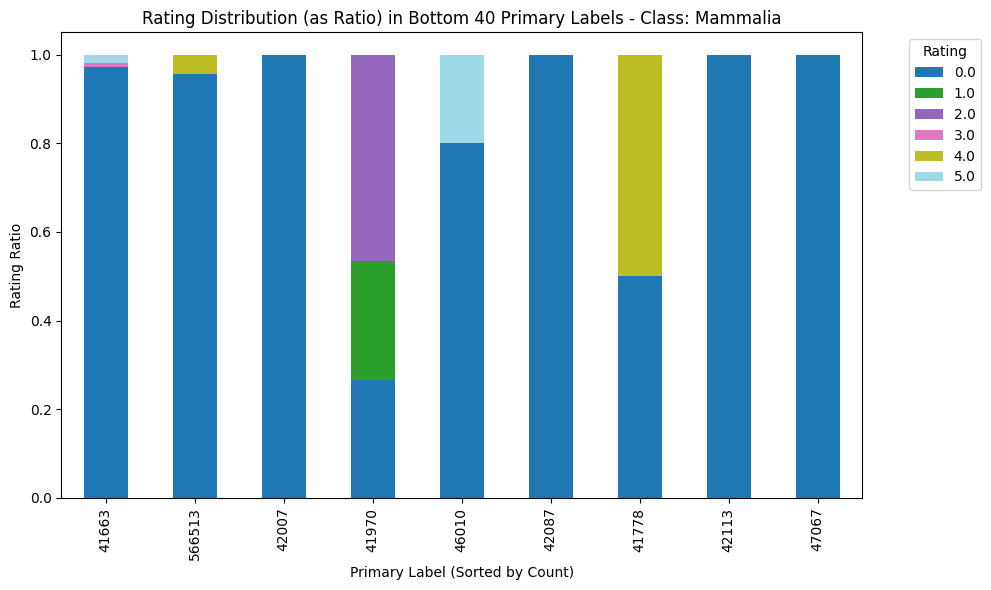

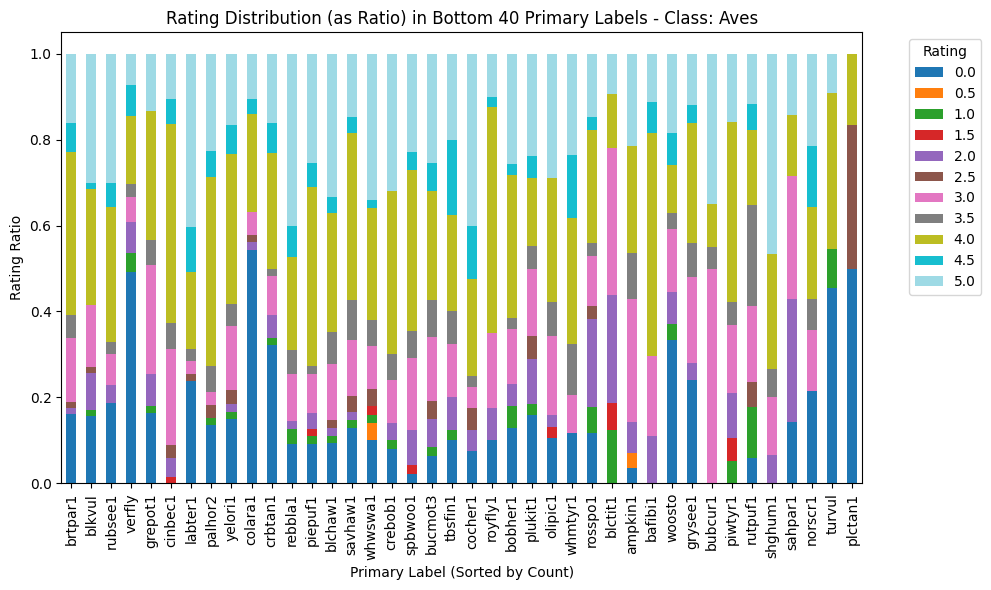

In [18]:
for class_name in df['class_name'].unique():
    # ボトム40の primary_label を抽出
    label_counts = df[df["class_name"] == class_name].value_counts("primary_label").tail(40)
    bottom_labels = label_counts.index.tolist()

    # ボトム40に該当する行だけ抽出
    subset = df[(df["class_name"] == class_name) & (df["primary_label"].isin(bottom_labels))]

    # primary_label × rating のクロス集計（件数）
    pivot = pd.crosstab(subset['primary_label'], subset['rating'])

    # ❗primary_label の出現数で降順にソート
    pivot['total_count'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('total_count', ascending=False)
    pivot = pivot.drop(columns='total_count')  # 可視化には不要

    # 割合に変換
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)

    # 積み上げ棒グラフ
    pivot_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    plt.title(f'Rating Distribution (as Ratio) in Bottom 40 Primary Labels - Class: {class_name}')
    plt.xlabel('Primary Label (Sorted by Count)')
    plt.ylabel('Rating Ratio')
    plt.xticks(rotation=90)
    plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

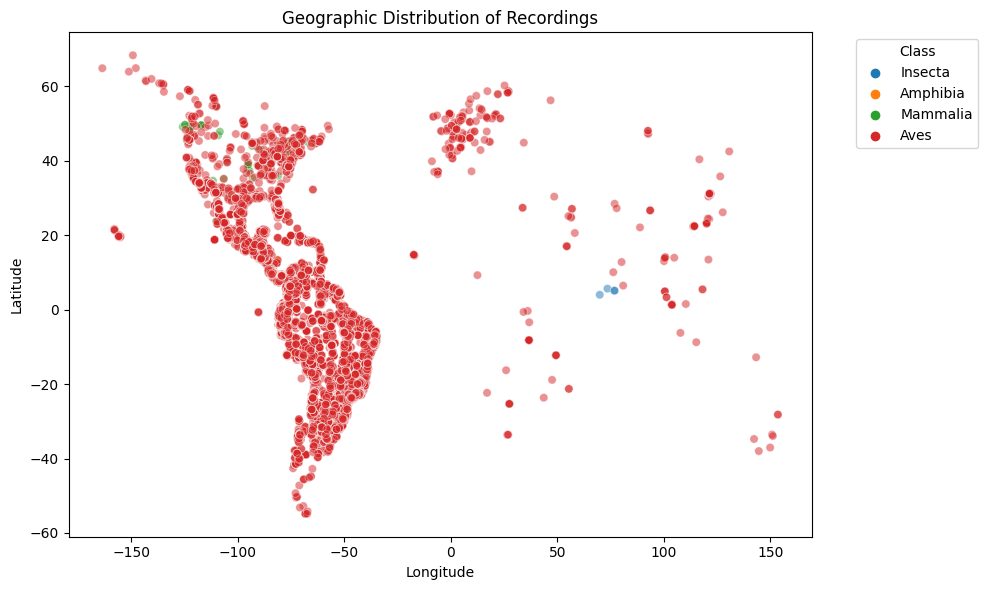

In [19]:
# --- 地理的分布の可視化 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='class_name', alpha=0.5)
plt.title('Geographic Distribution of Recordings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [99]:


def play_audio(filename, base_path):
    """
    音声ファイルを再生する。
    
    Parameters:
    - filename: メタデータに含まれるファイルパス（例: '1139490/CSA36385.ogg'）
    - base_path: self.train_datadir に相当するルートパス
    """
    filepath = os.path.join(base_path, filename)
    if os.path.exists(filepath):
        return Audio(filename=filepath)
    else:
        print("ファイルが見つかりません:", filepath)
        



In [100]:
# Insectaは最初に鳴いてる？その後人による解説

In [23]:
play_audio("rebbla1/XC560068.ogg", cfg.train_datadir)

In [24]:
df[df["class_name"] == "Insecta"].head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,inat_taxon_id,class_name
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta


In [88]:
import librosa
def inverse_melspec(mel_spec_norm, config):
    """
    正規化された Mel スペクトログラム（0〜1）を元の波形に近づけて再生。
    
    Parameters:
    - mel_spec_norm: 正規化済みメルスペクトログラム（float32, shape: (128, T)）
    - config: 設定オブジェクト（DatasetConfig）

    Returns:
    - IPython.display.Audio オブジェクト
    """

    # ① 0〜1 の正規化を元に戻す
    mel_spec_db = mel_spec_norm * (0 - (-80)) + (-80)  # librosa.power_to_db の typical range: [-80, 0]

    # ② dB → power
    mel_power = librosa.db_to_power(mel_spec_db)

    # ③ mel → STFT
    stft = librosa.feature.inverse.mel_to_stft(
    M=mel_power,
    sr=config.FS,
    n_fft=config.N_FFT,
    power=2.0,
    fmin=config.FMIN,
    fmax=config.FMAX
    )

    # ④ Griffin-Lim で波形復元
    waveform = librosa.griffinlim(
        stft,
        n_iter=32,
        hop_length=config.HOP_LENGTH,
        win_length=config.N_FFT
    )

    return Audio(waveform, rate=config.FS)

In [89]:
spec = np.load("../data/processed/mel_mixup/birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()

In [116]:
working_df = pd.read_csv("../data/processed/mel_mixup/train.csv")
working_df[working_df["primary_label"] == "woosto"].tail()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,n_augment,multi_crop,group_id,fold,is_mixup,mix_partner,mixup_weight
31908,woosto,['blbgra1'],[''],woosto/iNat640627.ogg,iNat,0.0,https://static.inaturalist.org/sounds/640627.m4a,26.4782,-80.1436,Mycteria americana,...,woosto-iNat640627_crop0,Aves,center,1,True,woosto-iNat640627,1,True,blbgra1-XC243284,0.7948
31909,woosto,['soulap1'],[''],woosto/iNat683978.ogg,iNat,0.0,https://static.inaturalist.org/sounds/683978.m4a,28.5736,-80.9910,Mycteria americana,...,woosto-iNat683978_crop0,Aves,center,1,True,woosto-iNat683978,2,True,soulap1-iNat607045,0.8433
31910,woosto,['bugtan'],[''],woosto/iNat684005.ogg,iNat,0.0,https://static.inaturalist.org/sounds/684005.m4a,28.5736,-80.9910,Mycteria americana,...,woosto-iNat684005_crop0,Aves,center,1,True,woosto-iNat684005,0,True,bugtan-XC446774,0.7542
31911,woosto,['littin1'],[''],woosto/iNat684010.ogg,iNat,0.0,https://static.inaturalist.org/sounds/684010.wav,28.5731,-80.9907,Mycteria americana,...,woosto-iNat684010_crop0,Aves,center,1,True,woosto-iNat684010,1,True,littin1-XC935058,0.7405
31912,woosto,['socfly1'],[''],woosto/iNat859775.ogg,iNat,0.0,https://static.inaturalist.org/sounds/859775.m4a,-3.0937,-79.8490,Mycteria americana,...,woosto-iNat859775_crop0,Aves,center,1,True,woosto-iNat859775,2,True,socfly1-XC82282,0.7628


In [121]:
mel = spec["woosto-iNat683978"]
utils_lib.inverse_melspec(mel, cfg)

In [120]:
mel = spec["woosto-iNat683978_crop0"]
utils_lib.inverse_melspec(mel, cfg)

In [122]:
mel = spec["soulap1-iNat607045"]
utils_lib.inverse_melspec(mel, cfg)

In [28]:
play_audio("1139490/CSA36389.ogg", cfg.train_datadir)

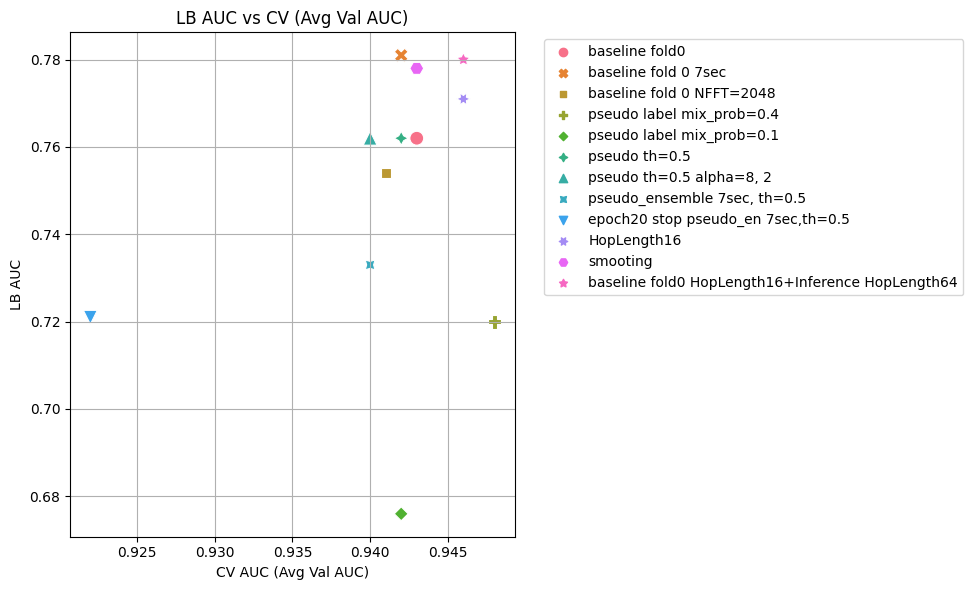

In [29]:
# LBとCVの比較
data = [
    {"Note": "baseline fold0", "LB AUC": 0.762, "Avg Val Auc": 0.943},
    {"Note": "baseline fold 0 7sec", "LB AUC": 0.781, "Avg Val Auc": 0.942},
    {"Note": "baseline fold 0 NFFT=2048", "LB AUC": 0.754, "Avg Val Auc": 0.941},
    {"Note": "baseline fold 0 NFFT=2048, epoch=20", "LB AUC": None, "Avg Val Auc": 0.942},
    {"Note": "pseudo label mix_prob=0.4", "LB AUC": 0.720, "Avg Val Auc": 0.948},
    {"Note": "pseudo label mix_prob=0.1", "LB AUC": 0.676, "Avg Val Auc": 0.942},
    {"Note": "pseudo th=0.5", "LB AUC": 0.762, "Avg Val Auc": 0.942},
    {"Note": "pseudo th=0.5 alpha=8, 2", "LB AUC": 0.762, "Avg Val Auc": 0.940},
    {"Note": "pseudo_ensemble 7sec, th=0.5", "LB AUC": 0.733, "Avg Val Auc": 0.940},
    {"Note": "epoch20 stop pseudo_en 7sec,th=0.5", "LB AUC": 0.721, "Avg Val Auc": 0.922},
    {"Note": "baseline batch128", "LB AUC": None, "Avg Val Auc": 0.923},
    {"Note": "baseline batch128 epoch20", "LB AUC": None, "Avg Val Auc": 0.935},
    {"Note": "HopLength16", "LB AUC": 0.771, "Avg Val Auc": 0.946},
    {"Note": "smooting", "LB AUC": 0.778, "Avg Val Auc": 0.943},
    {"Note": "FabioHead", "LB AUC": None, "Avg Val Auc": 0.945},
    {"Note": "baseline fold0 HopLength16+Inference HopLength64", "LB AUC": 0.780, "Avg Val Auc": 0.946}
]

# DataFrameの作成とプロット
auc_df = pd.DataFrame(data)
auc_df_plot = auc_df.dropna()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=auc_df_plot, x="Avg Val Auc", y="LB AUC", hue="Note", style="Note", s=100)
plt.title("LB AUC vs CV (Avg Val AUC)")
plt.xlabel("CV AUC (Avg Val AUC)")
plt.ylabel("LB AUC")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
train = pd.merge(train_label, taxonomy[["primary_label", "inat_taxon_id","class_name"]], on='primary_label', how='left')
train.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,inat_taxon_id,class_name
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1139490,Insecta
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1192948,Insecta


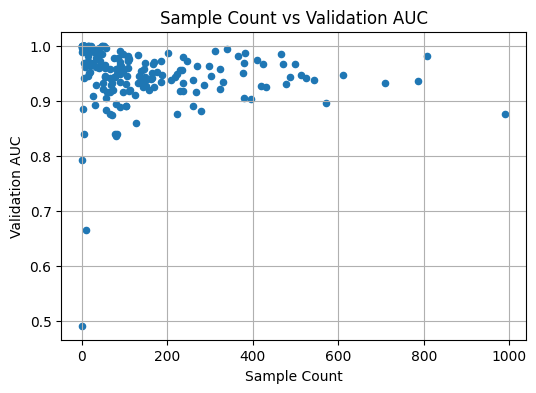

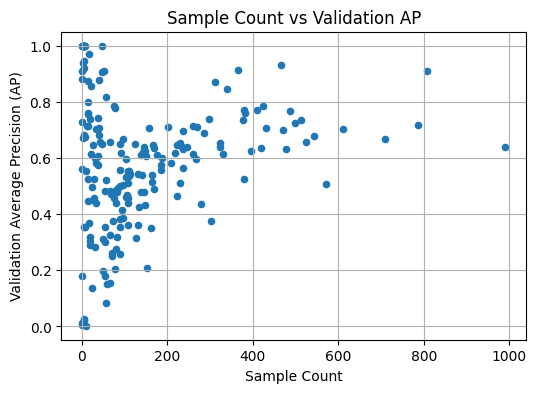

In [76]:
# サンプル数と性能の関係．mel_0411のfスコア
from glob import glob

# モデルスコアの保存場所
model_path = "../models/fold0_CropAug/"

# 全 fold のスコアファイルを取得
score_files = sorted(glob(os.path.join(model_path, "best_val_classwise_score_fold*.csv")))

# すべてのスコアを格納するリスト
all_scores = []

# 各 fold のスコアを読み込んでリストに追加
for file in score_files:
    df = pd.read_csv(file)
    all_scores.append(df)

# 全スコアを一つのDataFrameに統合
combined_df = pd.concat(all_scores)

# ラベルごとに平均を計算
mean_scores = combined_df.groupby("label").agg({
    "val_auc": "mean",
    "val_ap": "mean"
}).reset_index()


label_counts = train["primary_label"].value_counts().rename_axis("label").reset_index(name="sample_count")
# mean_scores（fold平均済み）とマージ
score_sample_df = mean_scores.merge(label_counts, on="label", how="left")

df = score_sample_df.copy()
# val_auc vs sample_count
plt.figure(figsize=(6, 4))
plt.scatter(df["sample_count"], df["val_auc"], s=20, )
plt.xlabel("Sample Count")
plt.ylabel("Validation AUC")
plt.title("Sample Count vs Validation AUC")
plt.grid(True)
plt.show()

# val_ap vs sample_count
plt.figure(figsize=(6, 4))
plt.scatter(df["sample_count"], df["val_ap"], s=20)
plt.xlabel("Sample Count")
plt.ylabel("Validation Average Precision (AP)")
plt.title("Sample Count vs Validation AP")
plt.grid(True)
plt.show()

# baselineよりもサンプル数が少ない部分の性能改善が見られる．

In [75]:
score_sample_df

,label,val_auc,val_ap,sample_count
0,1139490,0.987395,0.013699,2
1,1192948,1.000000,1.000000,4
2,126247,0.998950,0.142857,6
3,1346504,0.999125,0.166667,5
4,134933,0.996148,0.043478,4
...,...,...,...,...
193,yehcar1,0.910542,0.490362,238
194,yelori1,0.928543,0.215249,60
195,yeofly1,0.950875,0.642823,525
196,yercac1,0.917417,0.245386,302


In [73]:
score_sample_df

,label,val_auc,val_ap,sample_count
0,1139490,1.000000,1.000000,2
1,1192948,1.000000,1.000000,4
2,1194042,0.989512,0.669522,3
3,126247,1.000000,1.000000,6
4,1346504,0.994264,0.353190,5
...,...,...,...,...
192,yehcar1,0.931971,0.630654,238
193,yelori1,0.915313,0.152166,60
194,yeofly1,0.940706,0.657309,525
195,yercac1,0.944881,0.377177,302
